<a href="https://colab.research.google.com/github/sonialouise/ts_class/blob/main/notebooks/SpontaneousActivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spontaneous Neuronal Activity Classifier
This spontaneous neuronal activity classifier has been trained to detect if a neuron is spontaneously active in GCaMP6s *in vivo* calcium imaging
recordings. The model was trained on Delta F/F0 normalised data.  

### This notebook will enable you to:

**Use our trained activity classifier on your own data**

Our current model was trained on 151 second data at a sampling rate of 3.65Hz (a total of 551 frames). *Note that sampling rate for the test data must be the same as used for training*. If you are happy to test data of the same length (151s), but have recorded at a different sampling rate, that’s fine. We have included an interpolation step that adjusts your sampling rate to 3.65Hz.

**Use our data to retrain the activity classifier for different recording durations (greater or less than 151 seconds)**

If you would like to test a video that is longer or shorter than 151 seconds, you will have to retrain our activity classifier. This is because the training and test datasets need to have the same duration. Don’t worry though; you won’t have to generate your own annotated training data. You can use ours and simply ‘shorten or lengthen it’ (max length available: 301 seconds).

**Retrain the classifier on your own data**

If you have generated your own training data, (e.g. you have used lidocaine to check which neurons were active or not active in a given prep), then you can also use this to generate your very own, bespoke classifier.


## General instructions: 
To run each cell of the notebook, click the play arrow to the left. Alternatively, you can use shift + enter. 

Always run the next three cells to start with. 

Skip the section on ‘Model Retraining’ if you are happy to test a video of 151s duration. Otherwise run that section next. 

Execute the code under ‘Running the Classifier’ to obtain results on your own test data.


In [ ]:
#@markdown The Github repository with all custom functions, the model training datasets and the pretrained models are copied to the environment of this notebook. This will take a couple of seconds.

#@markdown *Note: You can check the code underlying each cell by double-clicking on it.*

import os

# If in Colab and not yet downloaded, download GitHub repository and change working directory
if os.getcwd() == '/content':  
    !git clone https://github.com/sonialouise/ts_class.git
    os.chdir('ts_class')
    
# If executed as jupyter notebook on own computer, change to parent directory for imports
if os.path.basename( os.getcwd() ) == 'activity_classifier':
    %cd ..
    print('New working directory:', os.getcwd() )

Cloning into 'ts_class'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 260 (delta 58), reused 65 (delta 46), pack-reused 168
Receiving objects: 100% (260/260), 21.36 MiB | 21.19 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [ ]:
#@markdown Run this cell to pull the latest version of the repository


!git pull 

Already up to date.


In [ ]:
#@markdown Download packages required to run the model

%%capture
!pip install -r requirements.txt

# python imports
import pickle
import argparse
import logging
import pandas as pd
import matplotlib.pyplot as plt

# ts_class packages, imported from the downloaded Github repository
from activity_classifier.main import run_model
from activity_classifier.config import TSF_MODEL, RISE_MODEL, OBS, PREDICTION, OUTPUT_PATH
from activity_classifier.prepare_data import prepare_data
from activity_classifier.retrain_models import retrain_tsf, retrain_rise
from math import floor
from copy import deepcopy

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)

# Model Retraining

If you have recordings greater or less than 151 seconds, model retraining is required. To do this, you can either use our labelled data or upload your own.
If using your own data, the format is important. Data should be in a .csv file, with the column names indicating the frame number. The final column should be named 'status' and contain the activity label: 'inactive' or 'active', depending on how you classified each cell. 

|0|1|2|3|...|status|
|-|-|-|-|---|------|
|0.134|0.224|0.123|0.444|...|active
|0.005|0.002|0.000|0.001|...|inactive

You can see an example of this by clicking the folder icon on the left (‘Files’). Within ‘Files’, there is a folder called ‘ts_class containing the following file: /content/ts_class/data/training_data.csv. Click on the three little dots next to the file name to download and open it. 
 


 
If you want to retrain the model on our data, update the duration field below per your requirements. Please note, the maximum duration available in our data is 301 seconds. For a longer duration, your own labelled data is required. 
If you are using your own data, enter the total recording duration in seconds. 



In [ ]:
#@markdown If you want to retrain on our data and just alter the recording duration, do not adjust the below file path (but still play this cell)

#@markdown To upload your own data, click on the folder symbol ("Files") on the left side of the Colaboratory notebook, and select the page icon with the ‘up’ arrow ( “'Upload to session storage”). 

#@markdown Find the file you want to upload on your computer and click “Open”. You should see your file appear in the ‘Files’ tab. Next enter path to your uploaded training data. To do this, click on the three little dots next to the file name in ‘Files’, and select ‘copy path’. 

#@markdown Insert this path here:

training_file_path = "data/training_data.csv" #@param {type:"string"}





In [ ]:
#@markdown If you want to retrain the model on our data, update the duration field below per your requirements. Please note, the maximum duration available in our data is 301 seconds. For a longer duration, your own labelled data is required. 

#@markdown If you are using your own data, enter the total recording duration in seconds

duration = 151 #@param {type:"number"}  

In [ ]:
#@markdown  If you want to retrain the model on our training data, do not adjust the below sampling (but still play this cell). 

#@markdown If you are using your own training data, enter the recording sampling rate (Hz). 

sampling_rate = 3.65 #@param {type: "number"}

train_total_frames = floor(duration * sampling_rate)


In [ ]:
#@markdown Play this cell to retrain the model. This should take approx 5 minutes. <br />
   
logging.info("1. Reading csv file...")
data = pd.read_csv(training_file_path, header=0)
logging.info("2. Normalising data...")
trace_data = deepcopy(data.iloc[:, 0:train_total_frames])
data = pd.concat([prepare_data(trace_data, duration, sampling_rate), data['status']], axis=1)
logging.info("3. Retraining Time Series Classifier...")
retrain_tsf(data)
logging.info("4. Retraining Random Interval Spectral Ensemble...")
retrain_rise(data)
logging.info("5. Retraining Complete")

RESULTS TSF: {'ACCURACY': 0.8990874791611827, 'PRECISION': 0.7941397460041528, 'RECALL': 0.7013227513227513}
RESULTS RISE: {'ACCURACY': 0.9656079085139364, 'PRECISION': 0.9676261994159366, 'RECALL': 0.8634605147458346}


# Running the classifier

In [ ]:
#@markdown To upload data, click on the folder symbol ("Files") on the left side of the Colaboratory notebook, and select the page icon with the ‘up’ arrow ( “'Upload to session storage”)'. 

#@markdown Find the file you want to upload on your computer and click “Open”. You should see your file appear in the ‘Files’ tab. 

#@markdown Your data have to be in .csv format, with each row containing a neuron and each column containing the data over time. You should not have row names, but each column should have the frame number at the top. You can see an example of this in the ts_class folder on the left here: /content/ts_class/data/test_data.csv. Click on the three little dots next to the file name to download and open it.  

#@markdown Please enter path to your uploaded test data. To do this, click on the three little dots next to the file name in ‘Files’, and select ‘copy path’.

#@markdown Insert this path here: 

file_path = "data/test_data.csv" #@param {type:"string"}


In [ ]:
#@markdown Enter your duration (seconds), and sampling rate (Hz) below (the duration should be the same as used for training).

#@markdown If your sampling rate is 3.65Hz leave interpolation = False.

#@markdown If your sampling rate is different to 3.65Hz, enter it below and select interpolation = True.

duration = 151 #@param {type:"number"}  

sampling_rate = 3.65 #@param {type: "number"}

interpolate = False #@param ["True", "False"] {type:"raw"}

run_total_frames = floor(sampling_rate * duration)

if interpolate:
  sampling_rate = 3.65  


In [ ]:
#@markdown Play this cell to prepare your data for the model. Data recorded at a higher frequency than the sampling rate above will be interpolated to the above frequency.

logging.info("1. Reading csv file...")
raw_data = pd.read_csv(file_path, header=0)
logging.info("2. Normalising data...")
trace_data = raw_data.iloc[:, 0:run_total_frames]
data = deepcopy(prepare_data(trace_data, duration, sampling_rate))


<Figure size 2160x21600 with 0 Axes>

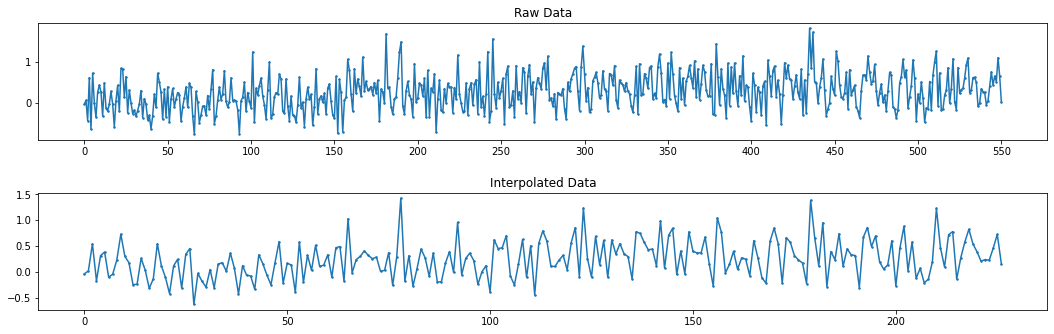

In [ ]:
#@markdown If you would like to view a comparison of raw and interpolated Delta F/F0 data for one of your neurons, please enter the row number to view below.
row_number = 1 #@param {type:"number"}  

plt.rcParams['figure.figsize'] = [15, 5]
plt.figure(figsize=(30,300))

fig, axs = plt.subplots(2)
axs[0].set_title('Raw Data')
axs[0].plot(trace_data.iloc[row_number, :run_total_frames], marker='.', markersize=3)
axs[0].set_xticks(range(0, len(trace_data.iloc[row_number, :run_total_frames]) + 1, 50))

axs[1].set_title('Interpolated Data')
axs[1].plot(data.iloc[row_number][OBS], marker='.', markersize=3)
axs[1].set_xticks(range(0, len(data.iloc[row_number][OBS]) + 1, 50))

fig.tight_layout(pad=2.0)


In [ ]:
#@markdown Play this cell to run the model on your data. The model predictions and the interpolated data can be found in the "Files" folder under ts_class -> data.

logging.info("3. Predicting with TimeSeries Forest Classifier...")
data = run_model(data, TSF_MODEL, 'TSF')
logging.info("4. Predicting with Random Interval Spectral Ensemble...")
data = run_model(data, RISE_MODEL, 'RISE')
logging.info("5. Saving output...")
data.to_csv(OUTPUT_PATH)
logging.info("6. Process complete")

In [ ]:
#@title
